In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import fastai
import pydicom as dicom
from pydicom.filereader import read_dicomdir
from fast_dicom import *

In [3]:
PATH = Path("/home/vhl_ai/Data/MRI/DICOMS")

In [4]:
class ProcessDCM():
    def __init__(self, study_path, new_spacing=np.array([1.,1.,1.])):
        self.new_spacing = new_spacing if new_spacing is not None else None
        self.study_path = study_path
        
    def get_scan(self, slices, is_scan=True):
        if is_scan == True:
            scan, px_spacing = self.proc_scan_files((slices))
        else:
            scan, px_spacing = self.proc_scan_files((slices))
            scan = np.where(scan != np.max(scan), 0, scan)
            
        return scan, px_spacing
    
    def proc_scan_files(self, slices):
        scan_files = (dicom.read_file(str(i)) for i in slices)
        scan_files = sorted(scan_files, key=lambda x: x.ImagePositionPatient[-1])
        
        #spacing information for conversion
        slice_dist = [abs(float(a.ImagePositionPatient[-1]) - float(b.ImagePositionPatient[-1])) for a,b in zip(scan_files[1:], scan_files[:-1])]
        slice_dist = max_agree(slice_dist)
        px_spacing = list(max_agree([tuple([float(i) for i in f.PixelSpacing]) for f in scan_files]))
        slice_dist, px_spacing
        
        #conversion should always be identity so this will almost always be redundant
        slope, intercept = map(float, [scan_files[0].RescaleSlope, scan_files[0].RescaleIntercept])
        stack = [(i.pixel_array * slope) + intercept for i in scan_files][::-1]
        slope, intercept, np.shape(stack)
    
        #remove extraneous slices with wrong dim
        max_dim = max_agree([i.shape for i in stack])
        stack = np.stack([i for i in stack if tuple(i.shape) == max_dim])
        return stack, np.array([slice_dist] + px_spacing[::-1])
    
class GetDCM():
    #Class for setting up mri scan and mask pathways to easily generate data
    def __init__(self, study_path):
        self.study_path = study_path
        
    def get_scan_names(self):
        #get list of all MRI scans in the dataset
        mri_scans = sorted([str(os.path.basename(i)) for i in (self.study_path).ls() if '.csv' not in str(i) ])
        return mri_scans
    
    def get_scan_mask(self):
        #retrieve all mri dicom slices from designated scan
        scan_list = self.get_scan_names()
        scan_slices = sorted([i for i in Path(PATH / scan_list[1] / 'Raw').ls()])
        mask_slices = sorted([i for i in Path(PATH / scan_list[1] / 'Mask').ls()])
        return scan_slices, mask_slices
        


In [5]:
gdcm = GetDCM(PATH)

In [6]:
foo_scan, foo_mask = gdcm.get_scan_mask()

In [7]:
PDCM = ProcessDCM(PATH)

In [8]:
foo_scan, foo_ps = PDCM.get_scan(foo_scan)
foo_mask, foo_mask_ps = PDCM.get_scan(foo_mask, is_scan=False)

In [9]:
np.shape(foo_mask), foo_mask_ps

((104, 512, 512), array([0.022789, 0.292969, 0.292969]))

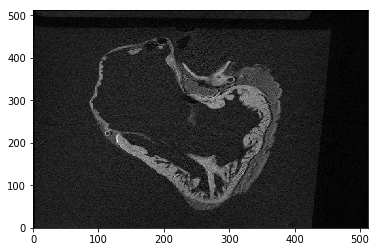

In [10]:
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flipud(foo_scan[73, :, :]))

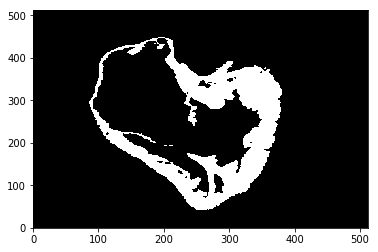

In [11]:
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flipud(foo_mask[73, :, :]))